In [3]:
from sdtw_div.numba_ops import *

In [4]:
from aeon.datasets import load_classification
X_te, y_te, meta_data = load_classification("ItalyPowerDemand", split="test", return_metadata=True, extract_path='/Data/aeon')
X_tr, y_tr, _ = load_classification("ItalyPowerDemand", split="train", return_metadata=True, extract_path='/Data/aeon')

In [5]:
X_tr[0].shape, X_tr.shape

((1, 24), (67, 1, 24))

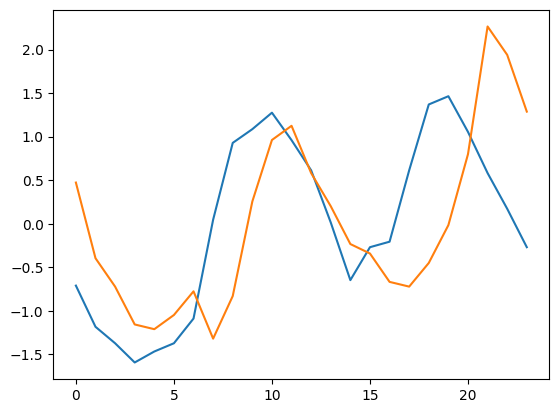

In [6]:
import matplotlib.pyplot as plt
import numpy as np
plt.plot(X_tr[0].ravel())
plt.plot(X_te[0].ravel())
plt.show()

In [7]:
n = 10
rng = np.random.default_rng(42)
classes = np.unique(y_tr)
k = rng.integers(0, len(classes))
X_a = X_tr[y_tr == classes[k]]

In [8]:
X_aa = X_a[rng.permutation(X_a.shape[0])[:n]]

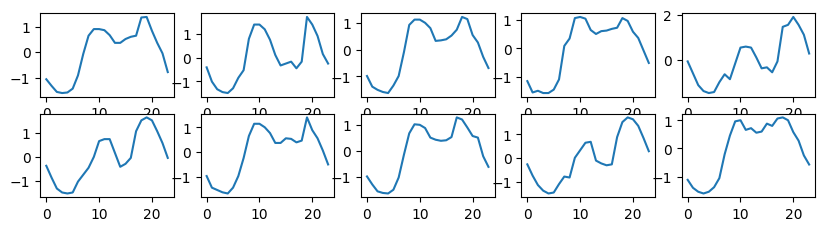

In [9]:
fig = plt.figure(figsize=(10, 5))
for i in range(n):
    ax = fig.add_subplot(4, 5, i + 1)
    ax.plot(X_aa[i].ravel())
plt.show()

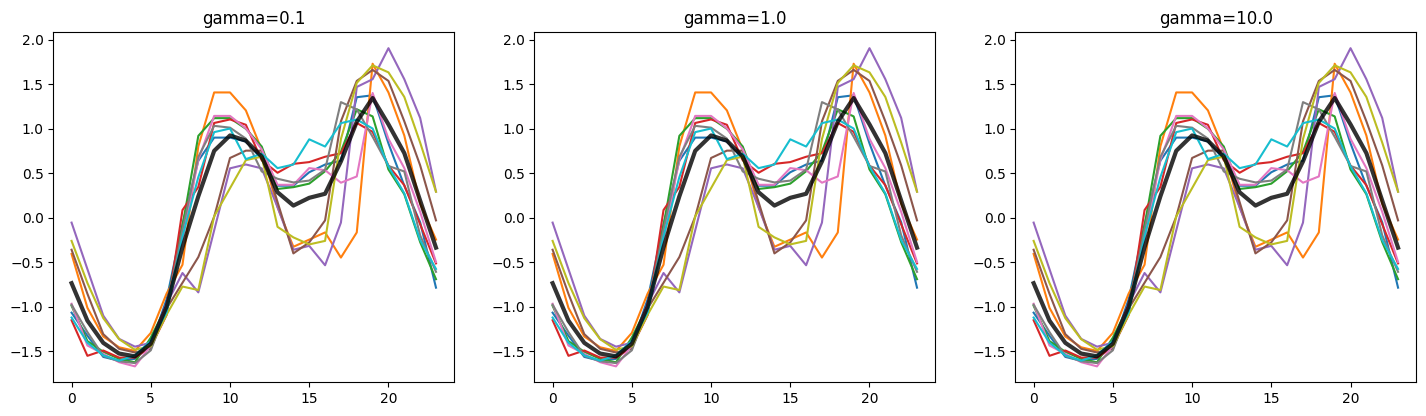

In [10]:
fig = plt.figure(figsize=(30, 10))
for i, gamma in enumerate([0.1, 1.0, 10.0]):
    ax = fig.add_subplot(2, 5, i + 1)
    for x in X_aa:
        ax.plot(x.ravel())
    value_and_grad = lambda X, Y: sdtw_value_and_grad(X, Y, gamma=gamma)
    Z = barycenter(X_aa, X_init="euclidean_mean", value_and_grad=value_and_grad, weights=None)
    ax.plot(Z.ravel(), color='k', linewidth=3, alpha=0.8)
    ax.set_title(f"gamma={gamma}")

plt.show()

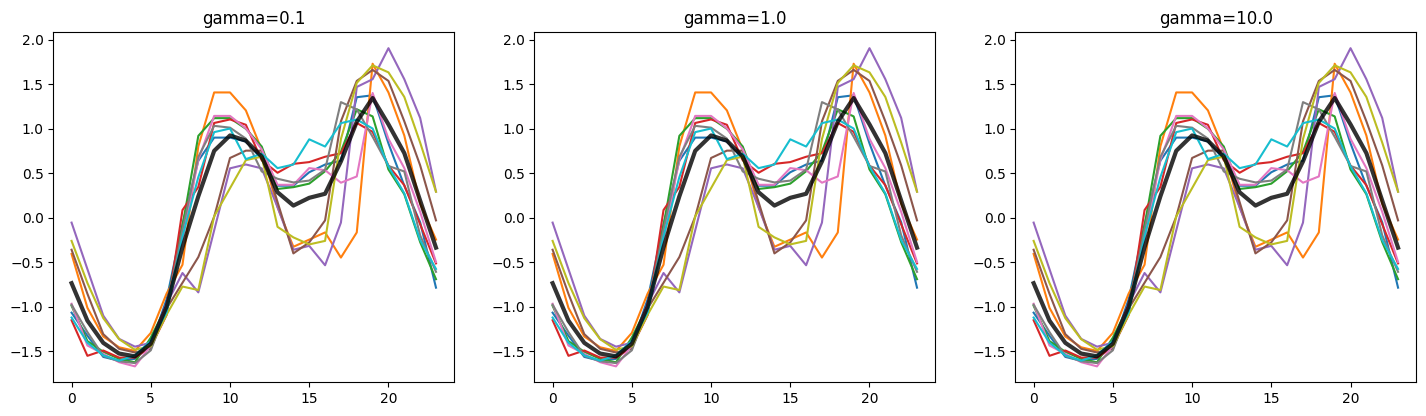

In [11]:
fig = plt.figure(figsize=(30, 10))
for i, gamma in enumerate([0.1, 1.0, 10.0]):
    ax = fig.add_subplot(2, 5, i + 1)
    for x in X_aa:
        ax.plot(x.ravel())
    value_and_grad = lambda X, Y: mean_cost_value_and_grad(X, Y) #, gamma=gamma)
    Z = barycenter(X_aa, X_init="euclidean_mean", value_and_grad=value_and_grad, weights=None)
    ax.plot(Z.ravel(), color='k', linewidth=3, alpha=0.8)
    ax.set_title(f"gamma={gamma}")

plt.show()

In [12]:
def load_ucr(dataset_name):
    # try:
    #     from tslearn.datasets import UCR_UEA_datasets
    #     ucr = UCR_UEA_datasets()
    #     X_train, y_train, X_test, y_test = ucr.load_dataset(dataset_name)
    # # tslearn returns 3D arrays (n_ts, sz, dim). We ensure dim=1 or keep as-is.
    #     return X_train, y_train, X_test, y_test
    # except Exception as e:
    #     raise RuntimeError('tslearn UCR loader failed. Please install tslearn (pip install tslearn). Error: ' + str(e))
    X_te, y_te, meta_data = load_classification(dataset_name, split="test", return_metadata=True, extract_path='/Data/aeon')
    X_tr, y_tr, _ = load_classification(dataset_name, split="train", return_metadata=True, extract_path='/Data/aeon')
    return X_tr, y_tr, X_te, y_te



In [13]:

# --------------------------
# plotting utilities
# --------------------------

def plot_series_list(series_list, labels=None, title=None, filename=None):
    """Plot multiple time series on one axis.

    The previous version dynamically increased the figure height based on the
    number of series, which could create extremely tall images. We keep a
    fixed figure size and just overlay the curves.
    """

    plt.figure(figsize=(9, 4))

    for i, s in enumerate(series_list):
        if hasattr(s, "ndim") and s.ndim == 2 and s.shape[1] == 1:
            s = s[:, 0]
        plt.plot(s, label=(labels[i] if labels else None), linewidth=1.2)

    if labels:
        plt.legend(loc="best")

    if title:
        plt.title(title)

    plt.tight_layout()

    if filename:
        plt.savefig(filename, dpi=150, bbox_inches="tight")
        plt.close()
    else:
        plt.show()


# --------------------------
# Experiment routines
# --------------------------

def experiment_average_10(dataset_name='UWaveGestureLibraryY', seed=0, divergence='sdtw_div', gamma=1.0):
    np.random.seed(seed)
    X_train, y_train, X_test, y_test = load_ucr(dataset_name)
    # pick k random series from train
    k=10
    n = len(X_train)
    idx = np.random.choice(n, size=min(k, n), replace=False)
    Ys = [X_train[i] for i in idx]
    # initial guess: euclidean mean
    X_init = euclidean_mean(Ys)
    if divergence == 'sdtw_div':
        valgrad = lambda X, Y: sdtw_div_value_and_grad(X, Y, gamma=gamma)
    elif divergence == 'mean_cost':
        valgrad = mean_cost_div_value_and_grad
    else:
        valgrad = lambda X, Y: sdtw_value_and_grad(X, Y, gamma=gamma)
    print('Computing barycenter')
    Xbar = barycenter(Ys, X_init=X_init, value_and_grad=valgrad, weights=None, method='L-BFGS-B', tol=1e-3, max_iter=200)
    plot_series_list([Xbar] + Ys, labels=['barycenter'] + ['Y%d' % i for i in range(len(Ys))],
                     title=f'Average of 10 series on {dataset_name}', filename=f'{dataset_name}_avg10.png')
    print('Saved plot to', f'{dataset_name}_avg10.png')
    return Xbar


def experiment_interpolation(dataset_name='ArrowHead', idx1=0, idx2=1, pis=(0.25, 0.5, 0.75), gamma=10.0):
    X_train, y_train, X_test, y_test = load_ucr(dataset_name)
    Y1 = X_train[idx1]
    Y2 = X_train[idx2]
    results = []
    for pi in pis:
        Ys = [Y1, Y2]
        weights = np.array([pi, 1.0 - pi])
        X_init = euclidean_mean(Ys, weights=weights)
        valgrad = lambda X, Y: sdtw_div_value_and_grad(X, Y, gamma=gamma)
        Xbar = barycenter(Ys, X_init=X_init, value_and_grad=valgrad, weights=weights, method='L-BFGS-B', tol=1e-3, max_iter=200)
        results.append((pi, Xbar))
    # Save plot
    series = [Y1, Y2] + [x for _, x in results]
    labels = ['Y1 (red)', 'Y2 (dark green)'] + [f'pi={pi}' for pi, _ in results]
    plot_series_list(series, labels=labels, title=f'Interpolation on {dataset_name}', filename=f'{dataset_name}_interp.png')
    print('Saved interpolation plot to', f'{dataset_name}_interp.png')
    return results


def experiment_barycenter_CBF(gamma=10.0):
    return experiment_average_10(dataset_name='CBF', divergence='sdtw_div', gamma=gamma)

# # --------------------------
# # Simple classification experiment (small-scale)
# # --------------------------

# def compute_divergence_matrix(Xs, fun, gamma=1.0):
#     n = len(Xs)
#     D = np.zeros((n, n))
#     for i in range(n):
#         for j in range(n):
#             D[i, j] = fun(Xs[i], Xs[j], gamma=gamma) if fun.__name__ == 'sdtw_div' else fun(Xs[i], Xs[j])
#     return D




In [ ]:

try:
    Xbar = experiment_average_10(dataset_name='UWaveGestureLibraryY', seed=1, divergence='sdtw_div', gamma=1.0)
except Exception as e:
    print('Error running average experiment:', e)   


Computing barycenter


/tmp/ipykernel_1458859/1972139925.py:26: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


Error running average experiment: Image size of 1121x105471 pixels is too large. It must be less than 2^16 in each direction.


ValueError: Image size of 747x72625 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 900x400 with 1 Axes>

In [61]:
X.shape

(67, 1, 24)

In [15]:

def load_data(dataset_name):
    # try:
    #     from tslearn.datasets import UCR_UEA_datasets
    #     ucr = UCR_UEA_datasets()
    #     X_train, y_train, X_test, y_test = ucr.load_dataset(dataset_name)
    # # tslearn returns 3D arrays (n_ts, sz, dim). We ensure dim=1 or keep as-is.
    #     return X_train, y_train, X_test, y_test
    # except Exception as e:
    #     raise RuntimeError('tslearn UCR loader failed. Please install tslearn (pip install tslearn). Error: ' + str(e))
    # X_te, y_te, meta_data = load_classification(dataset_name, split="test", return_metadata=True, extract_path='/Data/aeon')
    X_tr, y_tr, _ = load_classification(dataset_name, split="train", return_metadata=True, extract_path='/Data/aeon')
    return X_tr, y_tr #, X_te, y_te


def plot_barycenters(dataset_name, n_samples=10, gamma=10.0):
    print(f"\nRunning Averaging Experiment on {dataset_name}...")
    X_all, y_all = load_data(dataset_name)
    if X_all is None: return

    # Pick random samples (fixed seed for reproducibility)
    np.random.seed(42)
    indices = np.random.choice(len(X_all), n_samples, replace=False)
    Ys = [X_all[i].T for i in indices] # the data have shape (1, T) so i make it T x 1

    # Initialize results dictionary
    results = {}

    # 1. Euclidean Mean
    print("Computing Euclidean Mean...")
    results['Euclidean mean'] = euclidean_mean(Ys)

    # 2. Soft-DTW (Biased)
    # Init with Euclidean
    print(f"Computing Soft-DTW (gamma={gamma})...")
    results['SDTW'] = barycenter(
        Ys, X_init=results['Euclidean mean'], 
        value_and_grad=functools.partial(sdtw_value_and_grad, gamma=gamma)
    )

    # 3. Soft-DTW Divergence (Unbiased)
    # Init with SDTW result
    print(f"Computing SDTW Divergence (gamma={gamma})...")
    results['SDTW divergence'] = barycenter(
        Ys, X_init=results['SDTW'], 
        value_and_grad=functools.partial(sdtw_div_value_and_grad, gamma=gamma)
    )

    # 4. Sharp SDTW (Biased)
    print(f"Computing Sharp SDTW (gamma={gamma})...")
    results['Sharp SDTW'] = barycenter(
        Ys, X_init=results['Euclidean mean'], 
        value_and_grad=functools.partial(sharp_sdtw_value_and_grad, gamma=gamma)
    )

    # 5. Sharp Divergence (Unbiased)
    # Init with Sharp SDTW result
    print(f"Computing Sharp Divergence (gamma={gamma})...")
    results['Sharp divergence'] = barycenter(
        Ys, X_init=results['Sharp SDTW'], 
        value_and_grad=functools.partial(sharp_sdtw_div_value_and_grad, gamma=gamma)
    )

    # 6. Mean Cost (Biased)
    print("Computing Mean Cost...")
    results['Mean cost'] = barycenter(
        Ys, X_init=results['Euclidean mean'], 
        value_and_grad=mean_cost_value_and_grad
    )

    # 7. Mean Cost Divergence (Unbiased)
    # Init with Mean Cost result
    print("Computing Mean Cost Divergence...")
    results['Mean-cost divergence'] = barycenter(
        Ys, X_init=results['Mean cost'], 
        value_and_grad=mean_cost_div_value_and_grad
    )
    
    # 8. Approximation of DTW using small gamma SDTW
    print("Computing DTW approximation (SDTW gamma=0.1)...")
    results['DTW'] = barycenter(
        Ys, X_init=results['Euclidean mean'],
        value_and_grad=functools.partial(sdtw_value_and_grad, gamma=0.1)
    )

    # Plotting
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    fig.suptitle(f"Barycenters on {dataset_name}", fontsize=16)
    axes = axes.ravel()
    
    order = ['Euclidean mean', 'SDTW', 'Sharp SDTW', 'Mean cost',
             'DTW', 'SDTW divergence', 'Sharp divergence', 'Mean-cost divergence']

    for ax, name in zip(axes, order):
        # Plot background samples
        for Y in Ys:
            ax.plot(Y, color='k', alpha=0.1)
        
        # Plot barycenter
        # Colors mimicking the paper roughly
        color = 'tab:blue'
        if 'DTW' in name and 'Soft' not in name: color = 'orange'
        if 'SDTW' in name: color = 'tab:green'
        if 'SDTW divergence' in name: color = 'tab:red'
        if 'Sharp' in name: color = 'tab:purple'
        if 'Sharp divergence' in name: color = 'brown'
        if 'Mean' in name: color = 'tab:pink'
        if 'Mean-cost divergence' in name: color = 'tab:gray'

        # For the plot we need to flatten the (T, 1) array to (T,)
        ax.plot(results[name].ravel(), color=color, linewidth=2)
        ax.set_title(name)
        ax.set_ylim(results[name].min() - 1, results[name].max() + 1)
        
    plt.tight_layout()
    plt.show()

def plot_interpolation(dataset_name, gamma=1.0):
    print(f"\nRunning Interpolation Experiment on {dataset_name}...")
    X_all, y_all = load_data(dataset_name)
    if X_all is None: return

    # Pick two distinct time series
    np.random.seed(10) 
    # Trying to pick two that look different for better viz
    idx1, idx2 = 0, 1
    Y1 = X_all[idx1].T
    Y2 = X_all[idx2].T
    Ys = [Y1, Y2]

    weights_list = [
        [0.75, 0.25], # Closer to Y1
        [0.50, 0.50], # Middle
        [0.25, 0.75]  # Closer to Y2
    ]

    methods = {
        'Euclidean mean': (None, None),
        'SDTW': (functools.partial(sdtw_value_and_grad, gamma=gamma), 'Euclidean mean'),
        'Sharp SDTW': (functools.partial(sharp_sdtw_value_and_grad, gamma=gamma), 'Euclidean mean'),
        'Mean cost': (mean_cost_value_and_grad, 'Euclidean mean'),
        'DTW': (functools.partial(sdtw_value_and_grad, gamma=0.1), 'Euclidean mean'),
        'SDTW divergence': (functools.partial(sdtw_div_value_and_grad, gamma=gamma), 'SDTW'),
        'Sharp divergence': (functools.partial(sharp_sdtw_div_value_and_grad, gamma=gamma), 'Sharp SDTW'),
        'Mean-cost divergence': (mean_cost_div_value_and_grad, 'Mean cost')
    }

    # Pre-compute unbiased inits (biased counterparts)
    cache = {}
    
    # Prepare Plot
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    fig.suptitle(f"Interpolation on {dataset_name}", fontsize=16)
    axes = axes.ravel()
    
    order = ['Euclidean mean', 'SDTW', 'Sharp SDTW', 'Mean cost',
             'DTW', 'SDTW divergence', 'Sharp divergence', 'Mean-cost divergence']

    for ax, name in zip(axes, order):
        func, init_key = methods[name]
        
        # Plot Source and Target
        ax.plot(Y1.ravel(), color='red', alpha=0.3, label='Y1')
        ax.plot(Y2.ravel(), color='darkgreen', alpha=0.3, label='Y2')

        for w in weights_list:
            # Determine Initialization
            X_init = None
            if name == 'Euclidean mean':
                res = euclidean_mean(Ys, weights=w)
            else:
                # Need init
                if init_key == 'Euclidean mean':
                    X_init = euclidean_mean(Ys, weights=w)
                else:
                    # For divergences, use the cached result of the biased version with these weights
                    # Key for cache needs to include weights
                    cache_key = f"{init_key}_{w[0]}"
                    if cache_key in cache:
                        X_init = cache[cache_key]
                    else:
                        # Fallback if execution order is messed up (shouldn't happen with this list)
                        X_init = euclidean_mean(Ys, weights=w)

                res = barycenter(Ys, X_init=X_init, value_and_grad=func, weights=w)
            
            # Cache result for divergence initialization
            cache_key = f"{name}_{w[0]}"
            cache[cache_key] = res
            
            # Color logic
            # Gradual shift from red to green
            color_interp = plt.cm.autumn(w[0]) # Map weight to colormap
            
            ax.plot(res.ravel(), color=color_interp, linewidth=2)

        ax.set_title(name)
    
    plt.tight_layout()
    plt.show()




Running Averaging Experiment on UWaveGestureLibraryY...
Computing Euclidean Mean...
Computing Soft-DTW (gamma=10.0)...
Computing SDTW Divergence (gamma=10.0)...
Computing Sharp SDTW (gamma=10.0)...
Computing Sharp Divergence (gamma=10.0)...
Computing Mean Cost...
Computing Mean Cost Divergence...
Computing DTW approximation (SDTW gamma=0.1)...


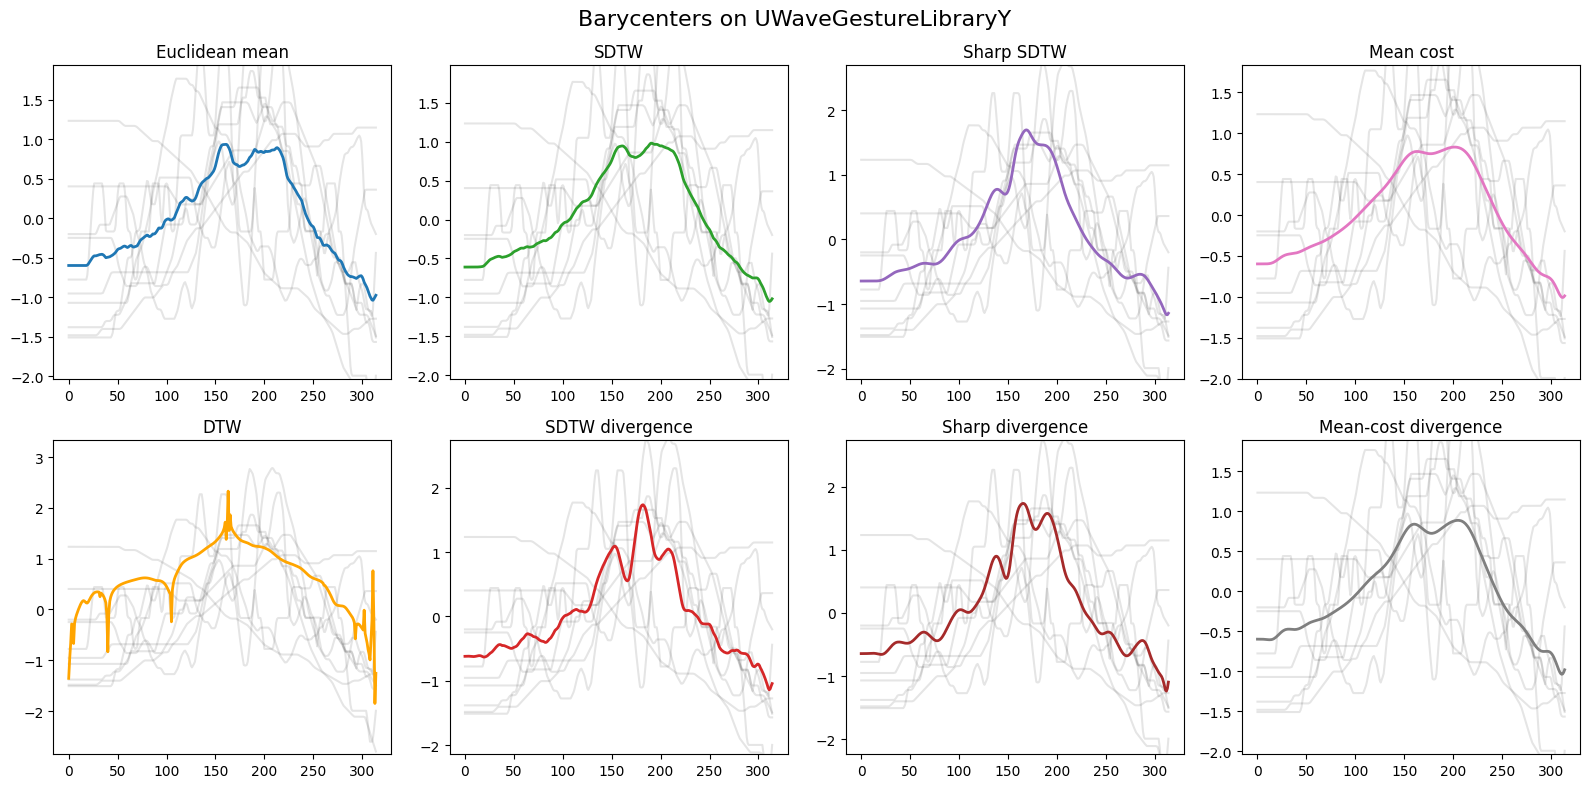

In [16]:

# Experiment 1: Barycenters on uWaveGestureLibrary_Y (Figure 3 in paper)
# The paper uses gamma=10 for uWave
plot_barycenters("UWaveGestureLibraryY", n_samples=10, gamma=10.0)



Running Averaging Experiment on CBF...
Computing Euclidean Mean...
Computing Soft-DTW (gamma=4)...
Computing SDTW Divergence (gamma=4)...
Computing Sharp SDTW (gamma=4)...
Computing Sharp Divergence (gamma=4)...
Computing Mean Cost...
Computing Mean Cost Divergence...
Computing DTW approximation (SDTW gamma=0.1)...


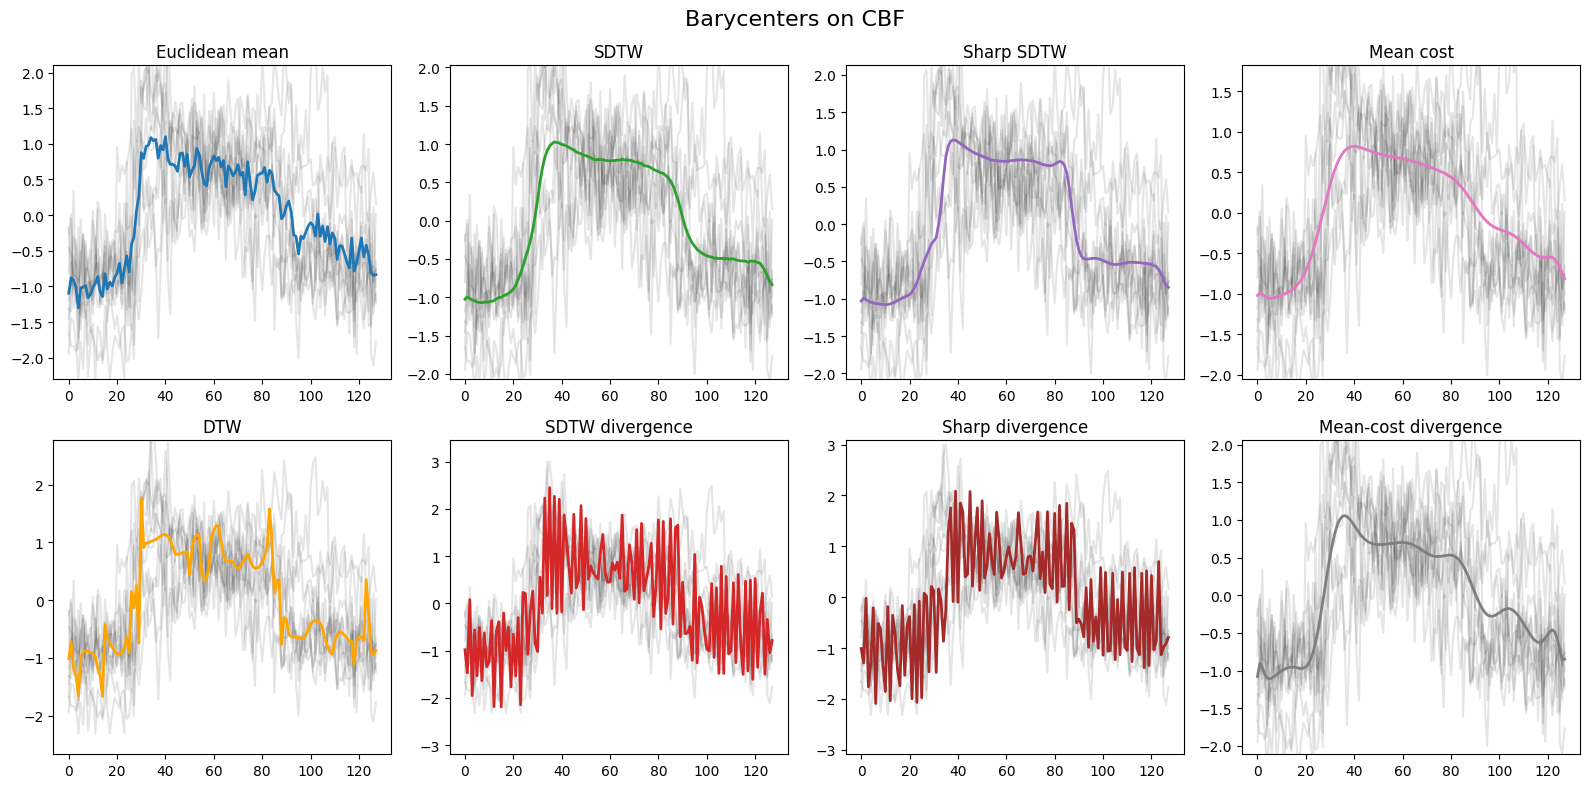

In [17]:

# Experiment 2: Barycenters on CBF (Additional example mentioned in text)
plot_barycenters("CBF", n_samples=10, gamma=4)



Running Interpolation Experiment on ArrowHead...


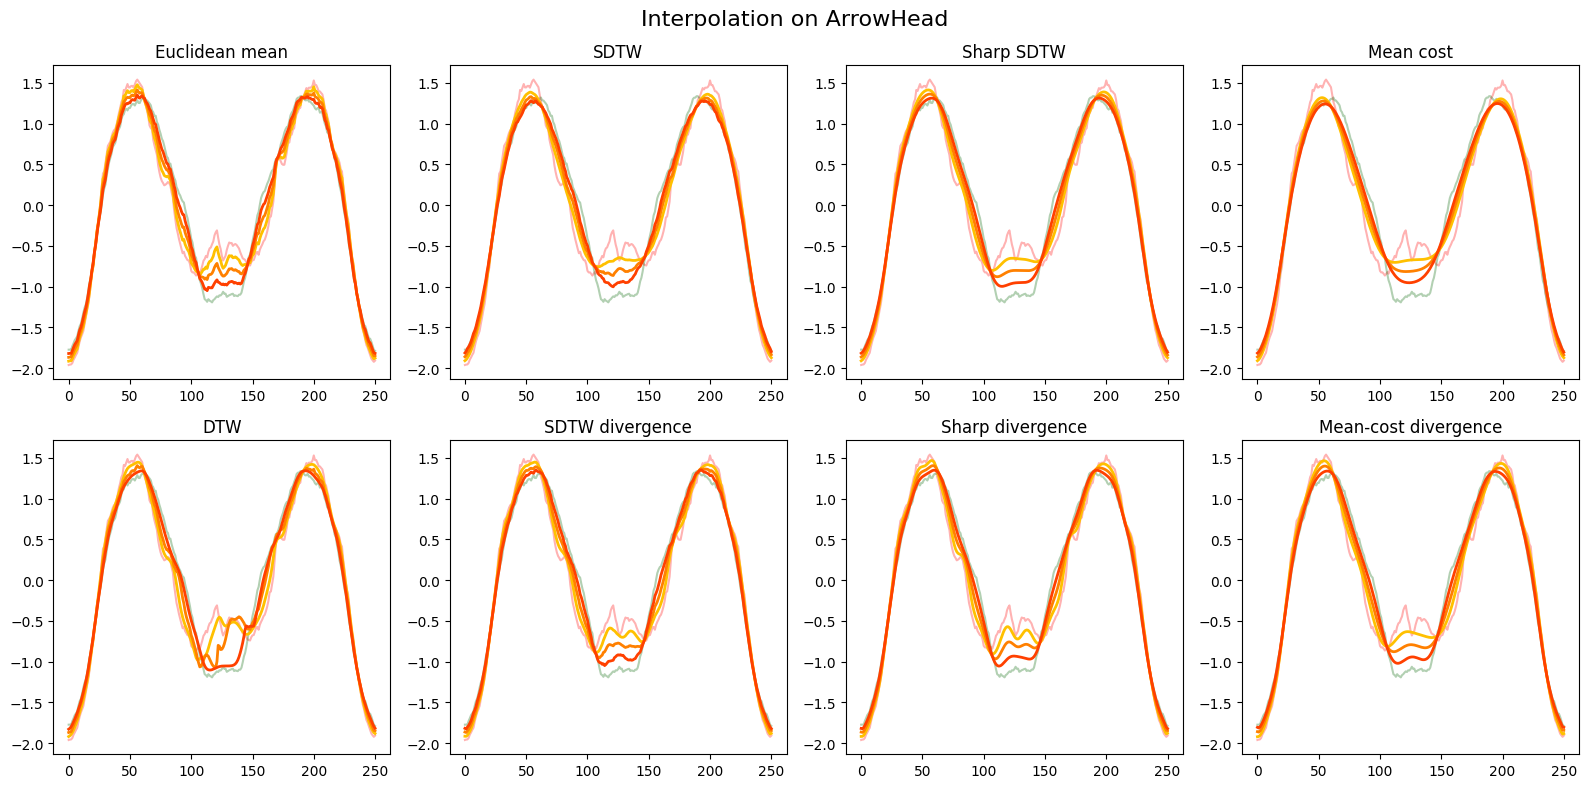

In [18]:

# Experiment 3: Interpolation on ArrowHead (Figure 4 in paper)
plot_interpolation("ArrowHead", gamma=10.0)

# New exps


In [19]:
import numpy as np
import matplotlib.pyplot as plt
import functools
from aeon.datasets import load_classification


def experiment_gamma_barycenter_evolution(X_train, n_samples=10, gammas=[0.01, 1.0, 10.0, 100.0]):
    """
    Visualizes how the shape of the barycenter evolves as gamma increases.
    """
    print(f"\n--- Experiment 1: Barycenter Evolution (n={n_samples}) ---")
    
    # Select random subset
    np.random.seed(42)
    indices = np.random.choice(len(X_train), n_samples, replace=False)
    Ys = [X_train[i].T for i in indices] # Shape (T, D)

    # 1. Compute Euclidean Mean (Limit as gamma -> infinity)
    euclidean_bar = euclidean_mean(Ys)

    fig, axes = plt.subplots(1, len(gammas) + 1, figsize=(20, 4), sharey=True)
    
    # Plot inputs in background
    for ax in axes:
        for y in Ys:
            ax.plot(y.ravel(), color='gray', alpha=0.1)
    
    # Iterate gammas
    for i, g in enumerate(gammas):
        print(f"Computing Soft-DTW Barycenter (gamma={g})...")
        
        # We use sdtw_div (Divergence) for the most mathematically robust centroid
        val_grad_fn = functools.partial(sdtw_div_value_and_grad, gamma=g)
        
        # Initialize with Euclidean mean for speed
        bary = barycenter(Ys, X_init=euclidean_bar, value_and_grad=val_grad_fn)
        
        axes[i].plot(bary.ravel(), 'r-', linewidth=2)
        axes[i].set_title(f"SDTW Div\n$\gamma={g}$")
        axes[i].grid(True, alpha=0.3)

    # Plot Euclidean Mean
    axes[-1].plot(euclidean_bar.ravel(), 'b-', linewidth=2)
    axes[-1].set_title("Euclidean Mean\n($\gamma \\to \infty$)")
    axes[-1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def experiment_gamma_variance_landscape(X_train, n_samples=5):
    """
    Analyzes the 'Fréchet Variance' (the minimized objective value) 
    as a function of gamma.
    """
    print(f"\n--- Experiment 2: Effect of Gamma on Fréchet Variance (n={n_samples}) ---")
    
    np.random.seed(42)
    indices = np.random.choice(len(X_train), n_samples, replace=False)
    Ys = [X_train[i].T for i in indices]
    
    gammas = np.logspace(-2, 2, 15) # From 0.01 to 100
    variances = []
    
    euclidean_bar = euclidean_mean(Ys)

    for g in gammas:
        # Calculate barycenter for this gamma
        val_grad_fn = functools.partial(sdtw_div_value_and_grad, gamma=g)
        bary = barycenter(Ys, X_init=euclidean_bar, value_and_grad=val_grad_fn, max_iter=50)
        
        # Calculate the total variance (sum of divergences)
        total_variance = 0
        for y in Ys:
            div = sdtw_div(bary, y, gamma=g)
            total_variance += div
        
        variances.append(total_variance / n_samples)

    plt.figure(figsize=(8, 5))
    plt.plot(gammas, variances, 'o-', color='purple')
    plt.xscale('log')
    plt.xlabel(r"Regularization strength $\gamma$ (log scale)")
    plt.ylabel("Fréchet Variance (Mean SDTW Divergence)")
    plt.title("Effect of $\gamma$ on the Minimum Variance")
    plt.grid(True, which="both", ls="-", alpha=0.5)
    plt.show()
    
    #  
    # This visualization helps understand convexity changes.

def experiment_gamma_alignment_sparsity(X_train):
    """
    Visualizes the alignment matrix (Gibbs distribution) to show how 
    entropy/sparsity changes with gamma.
    """
    print(f"\n--- Experiment 3: Alignment Sparsity vs Gamma ---")
    
    # Pick two distinct samples
    X = X_train[0].T
    Y = X_train[1].T
    
    gammas = [0.01, 0.1, 1.0, 10.0]
    
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    
    for i, g in enumerate(gammas):
        # Compute Cost Matrix
        C = squared_euclidean_cost(X, Y)
        
        # Get Probability Matrix P (Gradient of Soft-DTW w.r.t Cost)
        # Note: sdtw_grad_C returns the expected alignment E
        # We need to compute V, P first.
        V, P_tensor = sdtw_C(C, gamma=g, return_all=True)
        E = sdtw_grad_C(P_tensor)
        
        im = axes[i].imshow(E, origin='lower', cmap='viridis', vmin=0, vmax=1)
        axes[i].set_title(f"Alignment Matrix\n$\gamma={g}$")
        axes[i].axis('off')
        
    plt.suptitle("Evolution of Alignment Entropy (Sharp to Diffuse)")
    plt.tight_layout()
    plt.show()




--- Experiment 1: Barycenter Evolution (n=10) ---
Computing Soft-DTW Barycenter (gamma=0.01)...
Computing Soft-DTW Barycenter (gamma=1.0)...
Computing Soft-DTW Barycenter (gamma=10.0)...
Computing Soft-DTW Barycenter (gamma=100.0)...


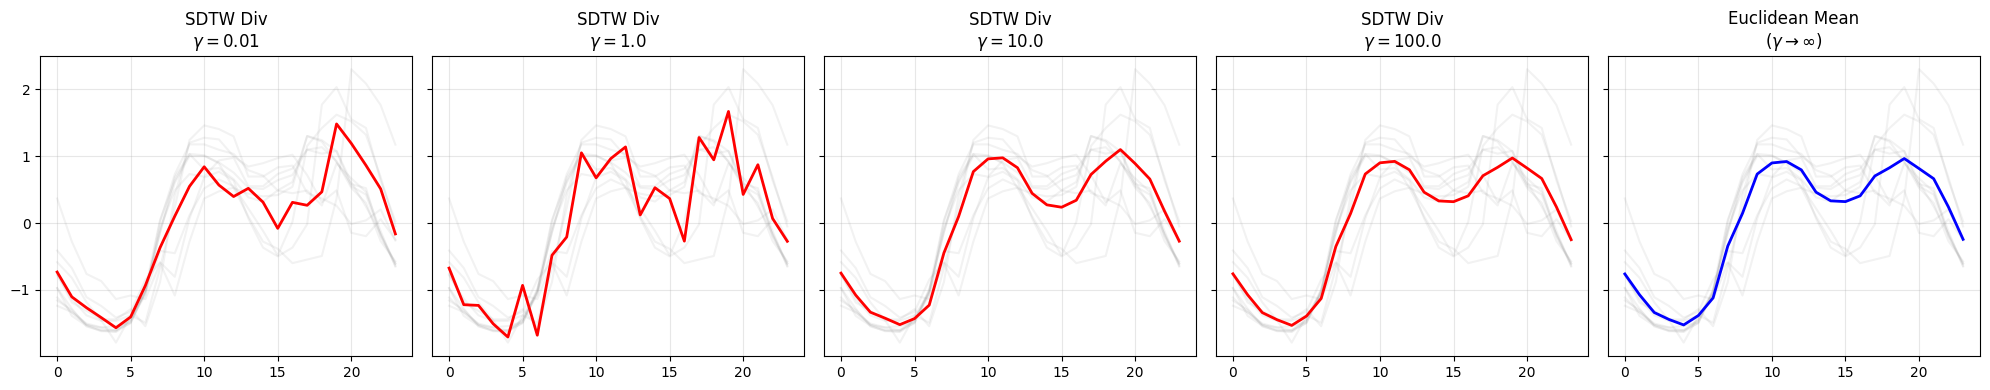


--- Experiment 2: Effect of Gamma on Fréchet Variance (n=5) ---


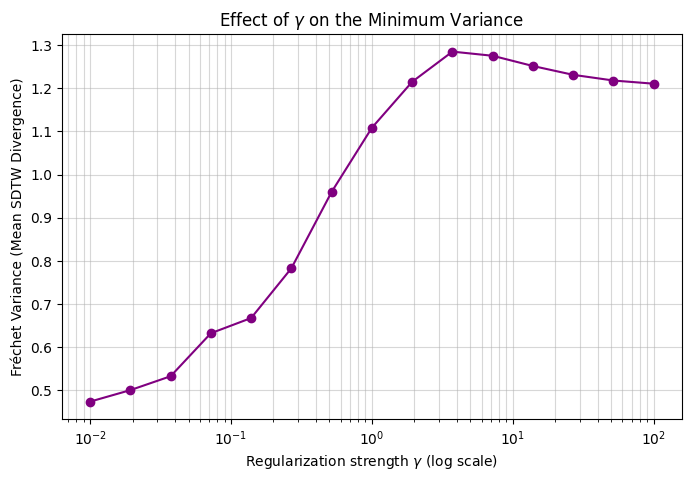


--- Experiment 3: Alignment Sparsity vs Gamma ---


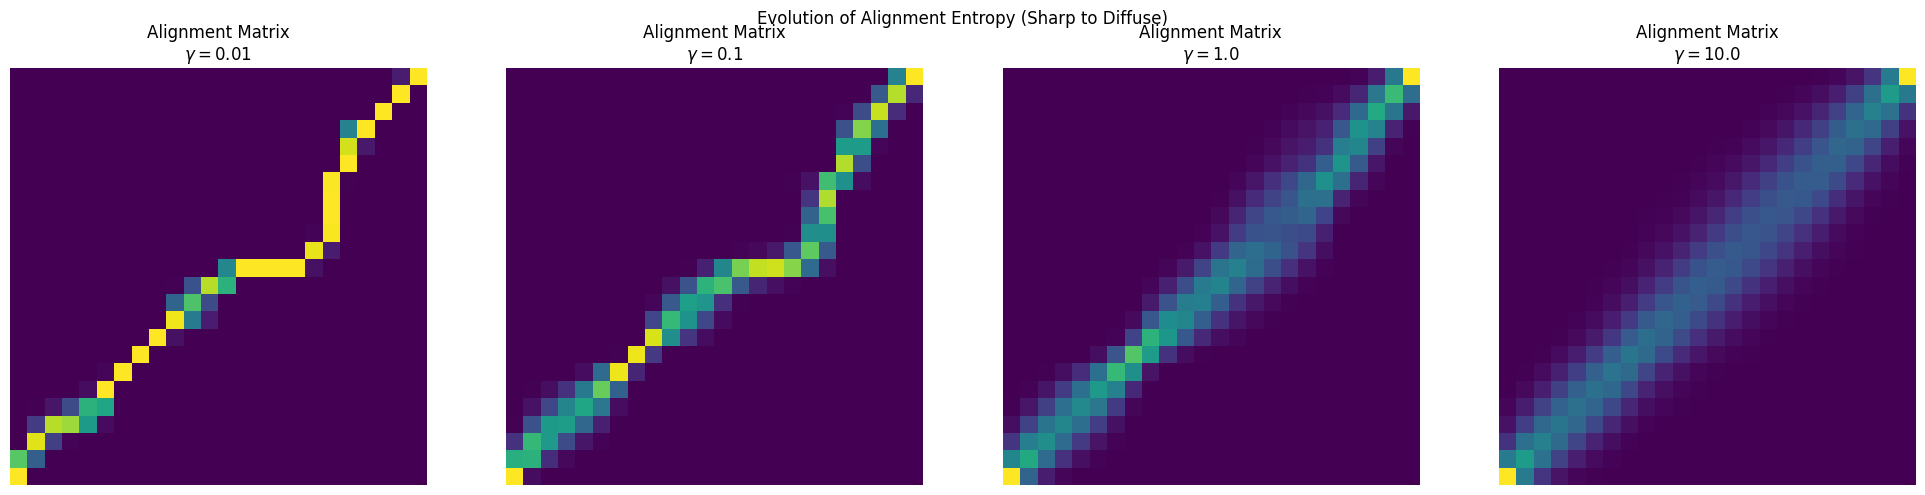

In [20]:

try:
    # Load dataset
    X_tr, y_tr, _ = load_classification("ItalyPowerDemand", split="train", return_metadata=True)
    
    # Experiment 1: Visual Evolution of the Barycenter
    experiment_gamma_barycenter_evolution(X_tr)
    
    # Experiment 2: Quantitative Variance
    experiment_gamma_variance_landscape(X_tr)
    
    # Experiment 3: Alignment Matrix Visualization
    experiment_gamma_alignment_sparsity(X_tr)
    
except Exception as e:
    print(f"Error running experiments: {e}")
    print("Ensure 'aeon' is installed or replace data loading with synthetic data.")